# 0. Setup

There are 3 files:
1. `maze.py`: defines the `MazeEnv` class, the simulation environment which the Q-learning agent will interact in.
2. `qlearning.py`: defines the `qlearn` function which you will implement, along with several helper functions.
3. `plotting_utils.py`: defines several plotting and visualization utilities. In particular, we will use `plot_steps_vs_iters`, `plot_several_steps_vs_iters`, `plot_policy_from_q`

In [1]:
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

from qlearning import qlearn
from maze import MazeEnv, ProbabilisticMazeEnv
from plotting_utils import plot_steps_vs_iters, plot_several_steps_vs_iters, plot_policy_from_q

# 1. Basic Q Learning experiments

Running the algorithm several times on the environment using the following hyperparameters:
1. Number of episodes = 200
2. Alpha ($\alpha$) learning rate = 1.0
3. Maximum number of steps per episode = 100. An episode ends when the agent reaches a goal state, or uses the maximum number of steps per episode
4. Gamma ($\gamma$) discount factor = 0.9

---


5. Epsilon ($\epsilon$) for $\epsilon$-greedy = 0.1 (10% of the time). Note that we should "break-ties" when the Q-values are zero for all the actions (happens initially) by essentially choosing uniformly from the action. So now you have two conditions to act randomly: for epsilon amount of the time, or if the Q values are all zero. 


In [2]:
# Set hyperparameters
num_iters = 200 
alpha = 1.0 
gamma = 0.9 
epsilon = 0.1 
max_steps = 100 
use_softmax_policy = False 

# Instantiate the MazeEnv environment with default arguments
env = MazeEnv() 

# Run Q-learning
q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)

Plot the steps to goal vs training iterations (episodes):

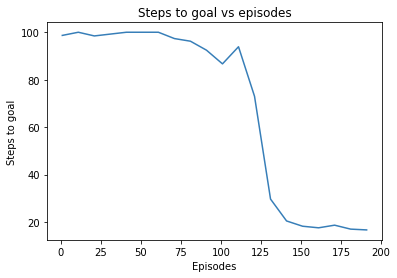

In [3]:
# Plot of steps vs iterations
plot_steps_vs_iters(steps_vs_iters)

Visualize the learned greedy policy from the Q values:

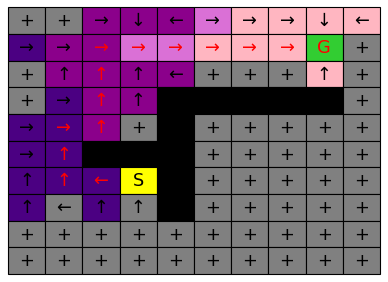

<Figure size 720x720 with 0 Axes>

In [4]:
# Plot the policy from the Q value
plot_policy_from_q(q_hat, env)

Running the algorithm by passing in a list of 2 goal locations: (1, 8) and (5, 6). Note: we are using 0-indexing, where (0, 0) is top left corner. Report on the results.

In [5]:
# Set hyperparameters
num_iters = 200 
alpha = 1.0 
gamma = 0.9 
epsilon = 0.1 
max_steps = 100 
use_softmax_policy = False 

# Set the goal
goal_locs = [[1, 8], [5, 6]] 
env = MazeEnv(goals=goal_locs) 

# Run Q-learning
q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)

Plot the steps to goal vs training iterations (episodes):

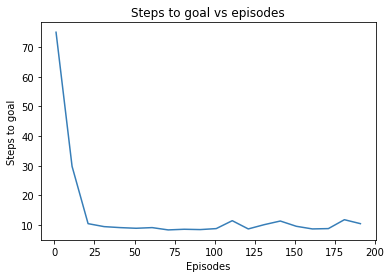

In [6]:
# Plot the steps vs iterations
plot_steps_vs_iters(steps_vs_iters)

Plot the steps to goal vs training iterations (episodes):

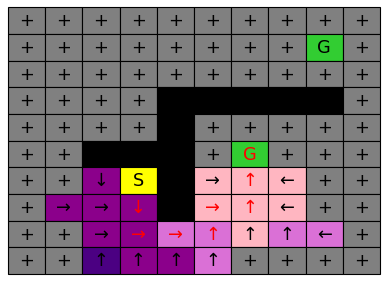

<Figure size 720x720 with 0 Axes>

In [7]:
# Plot the policy from the Q values
plot_policy_from_q(q_hat, env)

# 2. Experiment with the exploration strategy, in the original environment

Different $\epsilon$ values in $\epsilon$-greedy exploration: We use a rate of $\epsilon$=10%, and also 50% and 1%.

In [8]:
# Set hyperparametrs
num_iters = 200 
alpha = 1.0
gamma = 0.9
max_steps = 100
use_softmax_policy = False

# Set the epsilon lists in increasing order:
epsilon_list = [.01, .1, .5]

env = MazeEnv()

steps_vs_iters_list = []
for epsilon in epsilon_list:
   q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy)
   steps_vs_iters_list.append(steps_vs_iters)

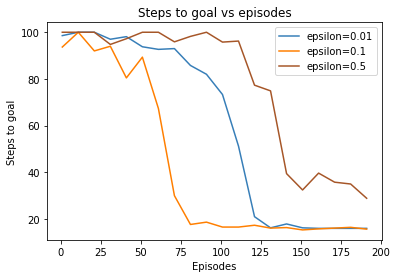

In [9]:
# Plot the results
label_list = ["epsilon={}".format(eps) for eps in epsilon_list]
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

Exploring with policy derived from softmax of Q-values. We use the values of $\beta \in \{1, 3, 6\}$ for this experiment, keeping $\beta$ fixed throughout the training.

In [10]:
# Set hyperparameters
num_iters = 200 
alpha = 1.0 
gamma = 0.9 
epsilon = 0.1
max_steps = 100 

# Set the beta
beta_list = [1, 3, 6] 
use_softmax_policy = True
k_exp_schedule = 0.0 # (float) choose k such that we have a constant beta during training

env = MazeEnv() 
steps_vs_iters_list = []
for beta in beta_list:
    q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy, beta, k_exp_schedule)
    steps_vs_iters_list.append(steps_vs_iters)

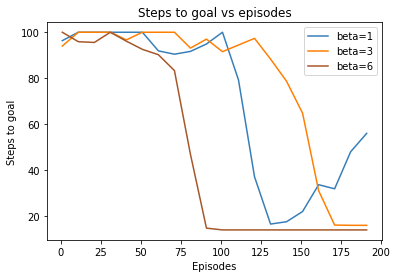

In [11]:
label_list = ["beta={}".format(beta) for beta in beta_list]
# TODO: 
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

Instead of fixing the $\beta = \beta_0$ to the initial value, we will increase the value of $\beta$ as the number of episodes $t$ increase:

$$\beta(t) = \beta_0 e^{kt}$$

That is, the $\beta$ value is fixed for a particular episode.
We run the training again for different values of $k \in \{0.05, 0.1, 0.25, 0.5\}$, keeping $\beta_0 = 1.0$.

In [12]:
# Set hyperparameters
num_iters = 200 
alpha = 1.0 
gamma = 0.9 
epsilon = 0.1 
max_steps = 100 

# Set the beta
beta = 1.0
use_softmax_policy = True 
k_exp_schedule_list = [.05, .1, .25, .5] 
env = MazeEnv() 

steps_vs_iters_list = []
for k_exp_schedule in k_exp_schedule_list:
    q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy, beta, k_exp_schedule)
    steps_vs_iters_list.append(steps_vs_iters)

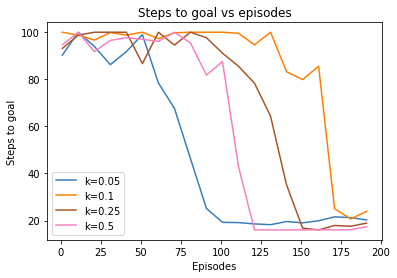

In [13]:
# Plot the steps vs iterations
label_list = ["k={}".format(k_exp_schedule) for k_exp_schedule in k_exp_schedule_list]
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)

# 3. Stochastic Environments

We make  the  environment  stochastic, such  that  the  agent  only  has  a  95% chance  of  moving  in  the  chosen  direction,  and  has  a  5%  chance  of  moving  in  some random direction.

We change the learning rule to handle the non-determinism, and experiment with different probability of environment performing random action $p_{rand} \in \{0.05, 0.1, 0.25, 0.5\}$ in this new rule.

The parameters will be the same as in previous part, except changing the alpha ($\alpha$) value to be **less than 1**.

In [14]:
# Use the same parameters as in the previous part, except changing alpha
num_iters = 200
alpha = 0.5
gamma = 0.9
epsilon = 0.1
max_steps = 100
use_softmax_policy = False

# Set the environment probability of random
env_p_rand_list = [.05, .1, .25, .5] 

steps_vs_iters_list = []
for env_p_rand in env_p_rand_list:
    # Instantiate with ProbabilisticMazeEnv
    env = ProbabilisticMazeEnv() 

    # Note: We will repeat for several runs of the algorithm to make the result less noisy
    avg_steps_vs_iters = np.zeros(num_iters)
    for i in range(10):
        q_hat, steps_vs_iters = qlearn(env, num_iters, alpha, gamma, epsilon, max_steps, use_softmax_policy, 1.0, k_exp_schedule)
        avg_steps_vs_iters += steps_vs_iters
    avg_steps_vs_iters /= 10
    steps_vs_iters_list.append(avg_steps_vs_iters)

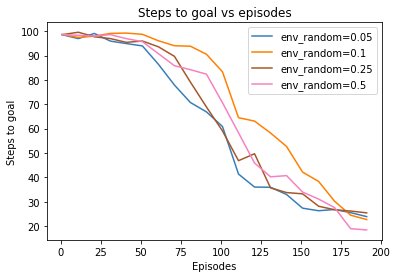

In [15]:
label_list = ["env_random={}".format(env_p_rand) for env_p_rand in env_p_rand_list]
plot_several_steps_vs_iters(steps_vs_iters_list, label_list)